# Lab Assigment 2 Estimation of Apparent Motion

<p style="text-align:left;">
    José Pedro Cruz
    <span style="float:right;">
        up201504646
    </span>
</p>
<p style="text-align:left;">
    Martinho Figueiredo
    <span style="float:right;">
        up201506179
    </span>
</p>
<p style="text-align:left;">
    Nuno Nascimento
    <span style="float:right;">
        up201907933
    </span>
</p>


[![GitHub](https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white)](https://github.com/martinhofigueiredo/VC)



## Scheme
```mermaid
flowchart LR
    A[Ingest Footage] -->|mp4 or mpegs| B{Multi Channel?}
    B -->|Yes| C[Split into Channels]
    B -->|No| D[Gray]-->H
    C --> E[R]-->H
    C --> F[G]-->H
    C --> G[B]-->H
    H{Multi Resolution?}-->|Yes|I[n Pyramid DownSampling Average]-->K
    H-->|No|J[One Shot]-->K
    K{algo} -->|HornShunck| M((.flo file))
    K -->|LucasKanade| M
```


## Benchmarking

```mermaid
flowchart LR
    GT[Ground truth] --> B{BenchMark}
    A(Flow Calculated) --> B
    B --> AE(Angular Error and Std Dev)
    B --> EE(Endpoint Error and Std Dev)
```


## Visualization
```mermaid
flowchart LR
    A[import .flo file]-->C{Type}
    C-->VF[Vector Field]
    C-->MF[Middlebury Flow]
    
```

# Setup

In [12]:
import cv2
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from scipy.ndimage.filters import convolve as filter2
import struct
import argparse
import math
from PIL import Image
%matplotlib inline


/tmp/ipykernel_5475/4116061769.py:7: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve as filter2


## Import Dataset

In [3]:
# IMport dataset with public ground truth
%pip install wget
import os
import subprocess
import wget
import zipfile

# Specify the URLs of the files to download
url1 = "https://vision.middlebury.edu/flow/data/comp/zip/other-gt-flow.zip"
url2 = "https://vision.middlebury.edu/flow/data/comp/zip/other-color-allframes.zip"
url3 = "https://vision.middlebury.edu/flow/data/comp/zip/eval-color-allframes.zip"
# Specify the destination folder to store the downloaded files
destination_folder = "dataset/"

# Download the files using wget
file1 = wget.download(url1, out=destination_folder)
file2 = wget.download(url2, out=destination_folder)
file3 = wget.download(url3, out=destination_folder)

# Unzip the files
with zipfile.ZipFile(file1, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

with zipfile.ZipFile(file2, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)
    
with zipfile.ZipFile(file3, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

# Remove the zip files if needed
os.remove(file1)
os.remove(file2)
os.remove(file3)

Note: you may need to restart the kernel to use updated packages.


## Ingest 

In [13]:
# Find all jpgs and pngs in a folder and returns a list of their respective path 
def get_frame_paths(folder_path):
    frame_paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            frame_path = os.path.join(folder_path, filename)
            frame_paths.append(frame_path)
    frame_paths.sort()
    ##print(frame_paths)
    return frame_paths

In [14]:
# Checks if the inut file is a directory and if it is it will try and get the frames inside the folder
# it will check if it is and mp4 and if it is it will read it and create a list of frames
def get_input_frames(input_path):
    frames = []
    if os.path.isdir(input_path):
        frame_paths = get_frame_paths(input_path)
        #print(f"{frame_paths}")
        frames = [cv2.imread(frame_path) for frame_path in frame_paths]
    else :
        #print("here")
        if input_path.endswith('.mp4') or input_path.endswith('.mov') :
            cap = cv2.VideoCapture(input_path)
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frames.append(frame)
            cap.release()
    return frames

## Load Algo Config from file

In [15]:
# Loads a yaml file with the parameters to run the code
def load_config(filename):
    with open(filename, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
        config['input_path']= os.getcwd()+config['input_path'] # Fix to run in the location it called
        #print(config)
    return config

## Flo file format Aux Functions

In [16]:
import struct
import numpy as np


def read_flow_field(file_path):
    with open(file_path, "rb") as f:
        # Read .flo header
        magic = struct.unpack('f', f.read(4))[0]
        width = struct.unpack('i', f.read(4))[0]
        height = struct.unpack('i', f.read(4))[0]

        # Ensure .flo file format
        assert magic == 202021.25, "Invalid .flo file format."

        # Read optical flow data
        flow_data = np.fromfile(f, np.float32, width * height * 2)
        flow_data = flow_data.reshape((height, width, 2))

    return flow_data


def write_flow_field(file_path, flow_data):
    height, width = flow_data.shape[:2]
    with open(file_path, "wb") as f:
        # Write .flo header
        f.write(struct.pack('f', 202021.25))
        f.write(struct.pack('i', width))
        f.write(struct.pack('i', height))

        # Write optical flow data
        flow_data.flatten().astype(np.float32).tofile(f)

In [17]:
def calculate_angular_error(flow_gt, flow_pred):
    flow_gt_norm = np.sqrt(np.sum(flow_gt ** 2, axis=2))
    flow_pred_norm = np.sqrt(np.sum(flow_pred ** 2, axis=2))
    dot_product = np.sum(flow_gt * flow_pred, axis=2)
    cos_theta = np.clip(dot_product / (flow_gt_norm * flow_pred_norm), -1.0, 1.0)
    angular_error = np.arccos(cos_theta)
    return angular_error

def calculate_endpoint_error(flow_gt, flow_pred):
    endpoint_error = np.sqrt(np.sum((flow_gt - flow_pred) ** 2, axis=2))
    return endpoint_error


def calculate_error_statistics(error):
    mean_error = np.mean(error)
    std_error = np.std(error)
    return mean_error, std_error




In [18]:
# Example usage
original_file = "/workspace/VC/assignment2/dataset/other-gt-flow/Urban2/flow10.flo"
new_file = "new.flo"

# Read the original .flo file
original_flow = read_flow_field(original_file)

# Write the original flow to a new .flo file
write_flow_field(new_file, original_flow)

# Read the new .flo file
new_flow = read_flow_field(new_file)

#Sanity check for write and read function

# Compare the original and new flow files
identical = np.array_equal(original_flow, new_flow)
print("The original and new files are identical:", identical)

angular_error = calculate_angular_error(original_flow, new_flow)
angular_mean, angular_std = calculate_error_statistics(angular_error)

#print('Mean Angular Error:', angular_mean)
#print('Standard Deviation of Angular Error:', angular_std)

endpoint_error = calculate_endpoint_error(original_flow, new_flow)
endpoint_mean, endpoint_std = calculate_error_statistics(endpoint_error)

print('Mean Endpoint Error:', endpoint_mean)
print('Standard Deviation of Endpoint Error:', endpoint_std)
os.remove(new_file)


The original and new files are identical: True
Mean Endpoint Error: 0.0
Standard Deviation of Endpoint Error: 0.0


# Lucas-Kanade

In [19]:
def computeLK_MC(frames, feature_params, lk_params, input_path):
    color = np.random.randint(0, 255, (100, 3))
    old_frame = frames[0]
    #old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    old_frameB, old_frameG, old_frameR = cv2.split(old_frame)
    
    p0B = cv2.goodFeaturesToTrack(old_frameB, mask=None, **feature_params)
    p0G = cv2.goodFeaturesToTrack(old_frameG, mask=None, **feature_params)
    p0R = cv2.goodFeaturesToTrack(old_frameR, mask=None, **feature_params)

    maskB = np.zeros_like(old_frame)
    maskG = np.zeros_like(old_frame)
    maskR = np.zeros_like(old_frame)

    for frame_num in frames[1:]:
        
        current_frame = frame_num
        #frame_gray = cv2.cvtColor(frame_num, cv2.COLOR_BGR2GRAY)
        current_frameB, current_frameG, current_frameR = cv2.split(frame_num)
        
        p1B, stB, err = cv2.calcOpticalFlowPyrLK(old_frameB, current_frameB, p0B, None, **lk_params)
        p1G, stG, err = cv2.calcOpticalFlowPyrLK(old_frameG, current_frameG, p0G, None, **lk_params)
        p1R, stR, err = cv2.calcOpticalFlowPyrLK(old_frameR, current_frameR, p0R, None, **lk_params)
        
        #print("p1: ", np.asarray(p1).shape)
        #print(np.asarray(p1).shape)
        #print(p1)
        if p1B is not None:
            
            good_newB = p1B[stB==1]
            good_oldB = p0B[stB==1]
        if p1G is not None:
            
            good_newG = p1G[stG==1]
            good_oldG = p0G[stG==1]
        if p1R is not None:
            
            good_newR = p1R[stR==1]
            good_oldR = p0R[stR==1]
        
        for i, (new, old) in enumerate(zip(good_newB, good_oldB)):
            aB, bB = new.ravel()
            cB, dB = old.ravel()
            maskB = cv2.line(maskB, (int(aB), int(bB)), (int(cB), int(dB)), color[i].tolist(), 2)
        for i, (new, old) in enumerate(zip(good_newG, good_oldG)):
            aG, bG = new.ravel()
            cG, dG = old.ravel()
            maskG = cv2.line(maskG, (int(aG), int(bG)), (int(cG), int(dG)), color[i].tolist(), 2)
        for i, (new, old) in enumerate(zip(good_newR, good_oldR)):
            aR, bR = new.ravel()
            cR, dR = old.ravel()
            maskR = cv2.line(maskR, (int(aR), int(bR)), (int(cR), int(dR)), color[i].tolist(), 2)
        
        # Calculate the displacement vectors
        flowB = good_newB - good_oldB
        flowG = good_newG - good_oldG
        flowR = good_newR - good_oldR

        # Prepare the flow matrix
        flow_dataB = np.zeros((current_frame.shape[0], current_frame.shape[1], 2), dtype=np.float32)
        valid_indicesB = np.where((good_oldB[:, 0] >= 0) & (good_oldB[:, 0] < current_frame.shape[1]) &
                                (good_oldB[:, 1] >= 0) & (good_oldB[:, 1] < current_frame.shape[0]))
        
        flow_dataG = np.zeros((current_frame.shape[0], current_frame.shape[1], 2), dtype=np.float32)
        valid_indicesG = np.where((good_oldG[:, 0] >= 0) & (good_oldG[:, 0] < current_frame.shape[1]) &
                                (good_oldG[:, 1] >= 0) & (good_oldG[:, 1] < current_frame.shape[0]))
        
        flow_dataR = np.zeros((current_frame.shape[0], current_frame.shape[1], 2), dtype=np.float32)
        valid_indicesR = np.where((good_oldR[:, 0] >= 0) & (good_oldR[:, 0] < current_frame.shape[1]) &
                                (good_oldR[:, 1] >= 0) & (good_oldR[:, 1] < current_frame.shape[0]))

        # Update flow matrix with valid keypoints and their displacement vectors
        valid_good_oldB = good_oldB[valid_indicesB].astype(int)
        flow_dataB[valid_good_oldB[:, 1], valid_good_oldB[:, 0]] = flowB.squeeze()[valid_indicesB]
        
        valid_good_oldG = good_oldG[valid_indicesG].astype(int)
        flow_dataG[valid_good_oldG[:, 1], valid_good_oldG[:, 0]] = flowG.squeeze()[valid_indicesG]
        
        valid_good_oldR = good_oldR[valid_indicesR].astype(int)
        flow_dataR[valid_good_oldR[:, 1], valid_good_oldR[:, 0]] = flowR.squeeze()[valid_indicesR]

        frame_with_flowB = cv2.add(current_frame, maskB)
        old_frameB = current_frameB.copy()
        p0B = good_newB.reshape(-1,1,2)
        
        frame_with_flowG = cv2.add(current_frame, maskG)
        old_frameG = current_frameG.copy()
        p0G = good_newG.reshape(-1,1,2)
        
        frame_with_flowR = cv2.add(current_frame, maskR)
        old_frameR = current_frameR.copy()
        p0R = good_newR.reshape(-1,1,2)
        
    if os.path.isfile(input_path):
        file_name, file_extension = os.path.splitext(input_path)
        if file_extension.lower() not in ['.png', '.jpg']:
            #print("File name without extension:", os.path.basename(file_name))
            cv2.imwrite(file_name+'_flow_B.png', frame_with_flowB)
            cv2.imwrite(file_name+'_flow_G.png', frame_with_flowG)
            cv2.imwrite(file_name+'_flow_R.png', frame_with_flowR)
            #write_flow_field(file_name+'_flow_field.flo',mask)
            # Save flow data to .flo file
            flow_data_mean = (flow_dataB+flow_dataG+flow_dataR)/3
            cv2.writeOpticalFlow(file_name+'_flow_field_mean.flo', flow_data_mean)
        else:
            print("The file extension is .png or .jpg")
    else:
        directory = input_path.split('dataset\\')[1].split('\\')
        #print("Directory after 'dataset\\':", directory[1])
        cv2.imwrite(directory[1]+'_flow_B.png', frame_with_flowB)
        cv2.imwrite(directory[1]+'_flow_G.png', frame_with_flowG)
        cv2.imwrite(directory[1]+'_flow_R.png', frame_with_flowR)
        write_flow_field(maskB,directory[1]+'_flow_field_B.flo')
        write_flow_field(maskG,directory[1]+'_flow_field_G.flo')
        write_flow_field(maskR,directory[1]+'_flow_field_R.flo')
    


In [30]:
def computeLK(frames, feature_params, lk_params, input_path):
    
    color = np.random.randint(0, 255, (100, 3))
    old_frame = frames[0]
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

    mask = np.zeros_like(old_frame)
    height, width, channels = old_frame.shape
    mask_flow = np.zeros((height,width,2))
    #print("DIM: ", mask_flow.shape)

    for frame_num in frames[1:]:
        
        current_frame = frame_num
        frame_gray = cv2.cvtColor(frame_num, cv2.COLOR_BGR2GRAY)
        
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        #print("p1: ", np.asarray(p1).shape)
        #print(np.asarray(p1).shape)
        #print(p1)
        if p1 is not None:
            
            good_new = p1[st==1]
            good_old = p0[st==1]
        
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        
        # Calculate the displacement vectors
        flow = good_new - good_old

        # Prepare the flow matrix
        flow_data = np.zeros((frame_gray.shape[0], frame_gray.shape[1], 2), dtype=np.float32)
        valid_indices = np.where((good_old[:, 0] >= 0) & (good_old[:, 0] < frame_gray.shape[1]) &
                                (good_old[:, 1] >= 0) & (good_old[:, 1] < frame_gray.shape[0]))

        # Update flow matrix with valid keypoints and their displacement vectors
        valid_good_old = good_old[valid_indices].astype(int)
        flow_data[valid_good_old[:, 1], valid_good_old[:, 0]] = flow.squeeze()[valid_indices]

    

        frame_with_flow = cv2.add(current_frame, mask)
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)
        
    if os.path.isfile(input_path):
        file_name, file_extension = os.path.splitext(input_path)
        if file_extension.lower() not in ['.png', '.jpg']:
            #print("File name without extension:", os.path.basename(file_name))
            cv2.imwrite(file_name+'_flow.png', frame_with_flow)
            #write_flow_field(file_name+'_flow_field.flo',flow_data)
            # Save flow data to .flo file
            cv2.writeOpticalFlow(file_name+'_flow_field.flo', flow_data)
            #write_flow_field(file_name+'_flow_field.flo',flow_data)
        else:
            print("The file extension is .png or .jpg")
    else:
        directory = input_path.split('dataset/')[1].split('/')
        #print("Directory after 'dataset\\':", directory[1])
        cv2.imwrite(directory[1]+'_flow.png', frame_with_flow)
        #write_flow_field(mask,directory[1]+'_flow_field.flo')
        cv2.writeOpticalFlow(directory[1]+'_flow_field.flo', flow_data)

In [31]:
#print(f"Loading File \'config_LK.yml\'")

config = load_config('config_LK.yml')

input_path = config['input_path']

frames = get_input_frames(config['input_path'])

#print(np.asarray(frames).shape)

feature_params = dict(
    maxCorners=config['max_corners'],
    qualityLevel=config['quality_level'],
    minDistance=config['min_distance'],
    blockSize=config['block_size']
)
lk_params = dict(
    winSize=(config['window_size'], config['window_size']),
    maxLevel=config['max_level'],
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, config['max_iterations'], config['epsilon'])
)

computeLK(frames, feature_params, lk_params, input_path)
#computeLK_MC(frames, feature_params, lk_params, input_path)






In [13]:
image = cv2.imread('/workspace/VC/assignment2/dataset/other-data/Urban2/frame07.png')

flow = read_flow_field('/workspace/VC/assignment2/dataset/other-gt-flow/Urban2/flow10.flo')

warped = cv2.remap(image, flow, None, cv2.INTER_LINEAR)

#cv2.imshow('warp', warped)
#cv2.waitKey(0)
#cv2.destroyAllWindows

# Horn-Shunchk

In [14]:
def computeHS_MC(path, name1, name2, alpha, delta):
    
    print("Computing using: ", name1, " and ", name2)

    beforeImg = cv2.imread(os.path.join(path, name1)).astype(float)
    afterImg = cv2.imread(os.path.join(path, name2)).astype(float)

    if beforeImg is None:
        raise NameError("Can't find image: \"" + name1 + '\"')
    elif afterImg is None:
        raise NameError("Can't find image: \"" + name2 + '\"')

    #removing noise
    beforeImg  = cv2.GaussianBlur(beforeImg, (5, 5), 0)
    afterImg = cv2.GaussianBlur(afterImg, (5, 5), 0)


    u_list = []
    v_list = []
    for i in range(3): # 3channels if this works im dumb
        # set up initial values
        u = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
        v = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
        fx, fy, ft = get_derivatives(beforeImg[:,:,i], afterImg[:,:,i])
        avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                                [1 / 6, 0, 1 / 6],
                                [1 / 12, 1 / 6, 1 / 12]], float)
        iter_counter = 0
        while True:
            iter_counter += 1
            u_avg = filter2(u, avg_kernel)
            v_avg = filter2(v, avg_kernel)
            p = fx * u_avg + fy * v_avg + ft
            d = 4 * alpha**2 + fx**2 + fy**2
            prev = u

            u = u_avg - fx * (p / d)
            v = v_avg - fy * (p / d)

            diff = np.linalg.norm(u - prev, 2)
            #converges check (at most 300 iterations)
            if  diff < delta or iter_counter > 300:
                # #print("iteration number: ", iter_counter)
                break
        u_list.append(u)
        v_list.append(v)



    u = (u_list[0]+u_list[1]+u_list[2])/3
    v = (v_list[0]+v_list[1]+v_list[2])/3
        
    draw_quiver(u, v, beforeImg, name1, name2)

    return u, v

def computeHS(path, name1, name2, alpha, delta):
    
    print("Computing using: ", name1, " and ", name2)
    beforeImg = cv2.imread(os.path.join(path, name1), cv2.IMREAD_GRAYSCALE)
    afterImg = cv2.imread(os.path.join(path, name2), cv2.IMREAD_GRAYSCALE)

    if beforeImg is None:
        raise NameError("Can't find image: \"" + name1 + '\"')
    elif afterImg is None:
        raise NameError("Can't find image: \"" + name2 + '\"')

    beforeImg = cv2.imread(os.path.join(path, name1), cv2.IMREAD_GRAYSCALE).astype(float)
    afterImg = cv2.imread(os.path.join(path, name2), cv2.IMREAD_GRAYSCALE).astype(float)

    #removing noise
    beforeImg  = cv2.GaussianBlur(beforeImg, (5, 5), 0)
    afterImg = cv2.GaussianBlur(afterImg, (5, 5), 0)

    # set up initial values
    u = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    v = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    fx, fy, ft = get_derivatives(beforeImg, afterImg)
    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                            [1 / 6, 0, 1 / 6],
                            [1 / 12, 1 / 6, 1 / 12]], float)
    iter_counter = 0
    while True:
        iter_counter += 1
        u_avg = filter2(u, avg_kernel)
        v_avg = filter2(v, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        diff = np.linalg.norm(u - prev, 2)
        #converges check (at most 300 iterations)
        if  diff < delta or iter_counter > 300:
            # #print("iteration number: ", iter_counter)
            break

    draw_quiver(u, v, beforeImg, name1, name2)

    
    return [u, v]

def show_image(name, image):
    print("take this image!!!")
    if image is None:
        return

    cv2.imshow(name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def get_magnitude(u, v):
    print("getting magnitude...")
    scale = 3
    sum = 0.0
    counter = 0.0

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1],8):
            counter += 1
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            sum += magnitude

    mag_avg = sum / counter

    return mag_avg

def draw_quiver(u,v,beforeImg,name1, name2):
    print("drawing...")
    scale = 3
    ax = plt.figure().gca()
    ax.imshow(beforeImg, cmap = 'gray')

    magnitudeAvg = get_magnitude(u, v)

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1],8):
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            #draw only significant changes
            if magnitude > magnitudeAvg:
                ax.arrow(j,i, dx, dy, color = 'red')

    plt.draw()
    file1 = os.path.splitext(name1)[0]
    file2 = os.path.splitext(name2)[0]
    plt.savefig('/workspace/VC/assignment2/output/'+file1+file2+'.png')
    plt.show()
    
def get_derivatives(img1, img2):
    print("derivating...")
    #derivative masks
    x_kernel = np.array([[-1, 1], [-1, 1]]) * 0.25
    y_kernel = np.array([[-1, -1], [1, 1]]) * 0.25
    t_kernel = np.ones((2, 2)) * 0.25

    fx = filter2(img1,x_kernel) + filter2(img2,x_kernel)
    fy = filter2(img1, y_kernel) + filter2(img2, y_kernel)
    ft = filter2(img1, -t_kernel) + filter2(img2, t_kernel)

    return [fx,fy, ft]

def calculate_aee(u, v, ground_truth_u, ground_truth_v):
    error = np.sqrt((u - ground_truth_u)**2 + (v - ground_truth_v)**2)
    aee = np.mean(error)
    return aee
def calculate_aee_std(u, v, ground_truth_u, ground_truth_v):
    error = np.sqrt((u - ground_truth_u)**2 + (v - ground_truth_v)**2)
    aee_std = np.std(error)
    return aee_std
def calculate_aae(u, v, ground_truth_u, ground_truth_v):
    error_cos = (u * ground_truth_u + v * ground_truth_v +
                 1.0) / (np.sqrt(u**2 + v**2 + 1.0) *
                         np.sqrt(ground_truth_u**2 + ground_truth_v**2 + 1.0))
    error_cos = np.clip(error_cos, -1.0, 1.0)  # Clip values to ensure valid range
    angular_error = np.arccos(error_cos)  # Calculate angular error in radians
    aae = np.degrees(np.mean(angular_error))  # Convert to degrees and calculate the mean
    return aae

def calculate_aae_std(u, v, ground_truth_u, ground_truth_v):
    error_cos = (u * ground_truth_u + v * ground_truth_v +
                 1.0) / (np.sqrt(u**2 + v**2 + 1.0) *
                         np.sqrt(ground_truth_u**2 + ground_truth_v**2 + 1.0))
    error_cos = np.clip(error_cos, -1.0, 1.0)  # Clip values to ensure valid range
    angular_error = np.arccos(error_cos)  # Calculate angular error in radians
    aae_std = np.degrees(np.std(angular_error))  # Convert to degrees and calculate the standard deviation
    return aae_std


Computing using:  frame07.png  and  frame08.png
derivating...
derivating...
derivating...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


drawing...
getting magnitude...


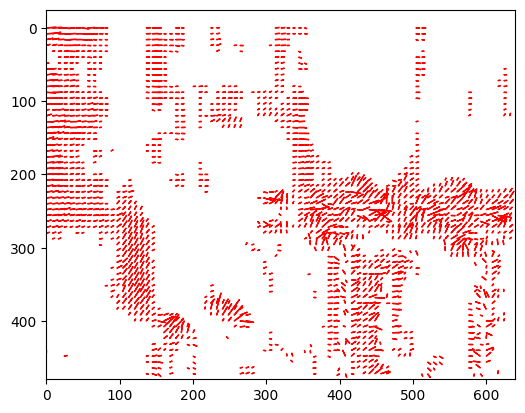

Average End-Point Error:  1.1543609207819743
Standard Deviation:  1.0739854966997353
Average Angular Error:  39.91779668191879
Standard Deviation:  22.333260591530347
Computing using:  frame08.png  and  frame09.png
derivating...
derivating...
derivating...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


drawing...
getting magnitude...


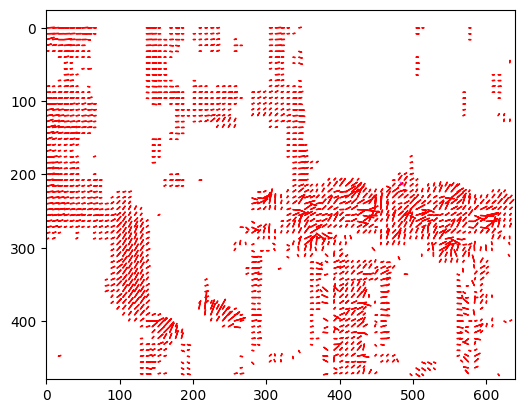

Average End-Point Error:  1.1600125361959597
Standard Deviation:  1.0379620013907822
Average Angular Error:  40.965349714711756
Standard Deviation:  20.85550283638559
Computing using:  frame09.png  and  frame10.png
derivating...


In [17]:
#print(f"Loading File \'config_HS.yml\'")

config = load_config('config_HS.yml')

input_path = config['input_path']

gt_path = '/workspace/VC/assignment2/dataset/other-gt-flow/Urban2/flow10.flo'

gt = read_flow_field(gt_path)

gt_u = gt[:, :, 0].astype(float) / 255.0  # Normalize u component to [0, 1]
gt_v = gt[:, :, 1].astype(float) / 255.0  # Normalize v component to [0, 1]
#name = get_frame_paths(input_path)
frames = os.listdir(input_path)
##print(frames)
aee_values = []
aee_std_values = []
aae_values = []
aae_std_values = []
for i in range(0,len(frames)-1):
    #print("CYCLE: ", i)
    u, v = computeHS_MC(input_path, frames[i], frames[i+1], alpha=15, delta=10**-1)
    
    aee = calculate_aee(u, v, gt_u, gt_v)
    aee_std = calculate_aee_std(u, v, gt_u, gt_v)
    print("Average End-Point Error: ", aee)
    print("Standard Deviation: ", aee_std)
    aee_values.append(aee)
    aee_std_values.append(aee_std)
    
    aae = calculate_aae(u, v, gt_u, gt_v)
    aae_std = calculate_aae_std(u, v, gt_u, gt_v)
    print("Average Angular Error: ", aae)
    print("Standard Deviation: ", aae_std)
    aae_values.append(aae)
    aae_std_values.append(aae_std)
    
print("MEAN AEE: ", np.mean(aee_values))
print("MEAN STD: ", np.mean(aee_std_values))
print("MEAN AAE: ", np.mean(aae_values))
print("MEAN STD: ", np.mean(aae_std_values))


# Visualization

Done Using [flowvid](https://github.com/diegoroyo/flowvid)

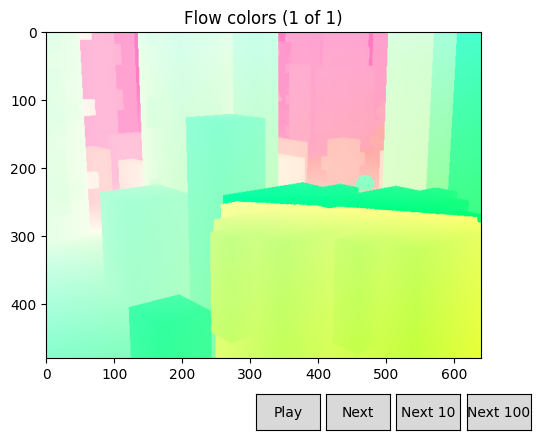

KeyboardInterrupt: 

In [16]:

import flowvid
import numpy as np
from IPython.display import HTML

import flowvid as fv

flo_data = fv.input.flo('/workspace/VC/assignment2/dataset/other-gt-flow/Urban2/flow10.flo')

# You can normalize by frame OR the whole video
# Normalize each flo file independently
flo_frame = fv.normalize_frame(flo_data)
# Normalize all flo files at once, applying a clamp/gamma curve
flo_video = fv.normalize_video(flo_data, clamp_pct=0.8, gamma=1.5)

# Conversion from flow data to RGB
rgb_frames = fv.flow_to_rgb(flo_video)

out5 = fv.output.show_plot(title='Flow colors', framerate=10)
out5.show_all(rgb_frames, show_count=True)





In [ ]:
import base64
def create_gif_from_folder(folder_path, duration=100, loop=0):
    gif_file = os.path.join(os.getcwd()+'/gifs/', f"{os.path.basename(folder_path)}.gif")
    #print(gif_file)
    images = []
    png_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.png')])

    for file in png_files:
        image_path = os.path.join(folder_path, file)
        image = Image.open(image_path)
        images.append(image)

    images[0].save(gif_file, save_all=True, append_images=images[1:], format='GIF', duration=duration, loop=loop)
    return gif_file

def gif_to_html_image(gif_file):
    with open(gif_file, 'rb') as f:
        gif_data = f.read()

    base64_data = base64.b64encode(gif_data).decode('utf-8')
    html_image = f'<img src="data:image/gif;base64,{base64_data}" />'

    return html_image


# Example usage
#folder_path = '/workspace/VC/assignment2/dataset/other-data/Urban2'
#create_gif_from_folder(folder_path, duration=200, loop=3)


# Bench Marking


In [ ]:
## Not Finished unfortunately :(

import pandas as pd
from IPython.display import display, Markdown


def find_common_folders(folder1, folder2):
    folders1 = set(os.listdir(os.getcwd()+folder1))
    folders2 = set(os.listdir(os.getcwd()+folder2))
    common_folders = list(folders1.intersection(folders2))
    print(f"Folders that have a ground truth to evaluate:{common_folders}")
    return common_folders



def display_results():
    # Create an empty dataframe to store the results

    paths_to_evalutate = find_common_folders('/dataset/other-data/','/dataset/other-gt-flow/')

    lk_df = pd.DataFrame(columns=['Name','Source', 'Processed', 'Average Angular Error','Std Angular Error', 'Average Endpoint Error','Std Endpoint Error'])
    hs_df = pd.DataFrame(columns=['Name','Source', 'Processed', 'Average Angular Error','Std Angular Error', 'Average Endpoint Error','Std Endpoint Error'])
    
    # Iterate through the function calls and store the results
    for i, path, in enumerate(paths_to_evalutate):
        source_path = os.getcwd()+'/dataset/other-data/'+path
        # Add the function name and result to the dataframe
        #source_gif = f"![source]({create_gif_from_folder(source_path, duration=100)})"
        source_gif = gif_to_html_image(create_gif_from_folder(source_path, duration=100))
        #lk_df.loc[i+1] = [path,source_gif,'yes','30days',source_gif,'yes','30days']
        hs_df.loc[i+1] = [path,source_gif,'yes','30days',source_gif,'yes','30days']

    #Display the results as a markdown table
    #display(Markdown('# LucasKanade Results\n\n'+lk_df.to_markdown(index=False)+'\n\n\n# HornShunck Results\n\n'+hs_df.to_markdown(index=False)))
    display(Markdown('\n# HornShunck Results\n\n'+hs_df.to_markdown(index=False)))
display_results()

# Lucas Kanade

|Sequence|Original|MR|MR+IR|Ours|
|:----|:----|:----|:----|:---|
|Dimetrodon [1]:|21.23 (21.26)|12.66 (19.05)|12.39 (18.73)||
|Grove2 [1]:|28.84 (21.20)|4.5  (9.80)|4.81  (9.58)||
|Grove3 [1]:|32.74 (31.50)|9.27  (17.98)|9.  6  (18.21)||
|RubberWhale [1]:|18.52 (21.74)|14.23 (21.54)|14.15 (21.66)||
|Hydragea  [1]:|27.87 (24.81)|9.27  (18.90)|9.  1  (19.56)||
|Urban2 [1]:|45.47 (41.04)|9.19  (18.03)|9.  4  (20.14)||
|Urban3  [1]:|48.14 (43.20)|7.74  (20.36)|7.  0  (18.84)||